# Self-Driving Car Engineer Nanodegree


## Project: **Vehicle Detection and Tracking** 
***
In this project, your goal is to write a software pipeline to identify vehicles in a video from a front-facing camera on a car. The test images and project video are available in the project repository. There is an writeup template in the repostitory provided as a starting point for your writeup of the project.

---

## Import Packages

In [1]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
import os
import pickle
import random 
import time
%matplotlib inline

## Read image data

Loading data...
cars length is:  8792
notcars length is:  8968
Your function returned a count of 8792  cars and 8968  non-cars
of size:  (64, 64, 3)  and data type: float32
image shape:   (64, 64, 3)
Done ...


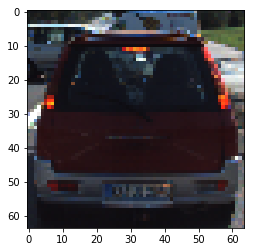

In [2]:
print('Loading data...')

car_file_dir = 'data/vehicles/'
car_filelist = os.listdir(car_file_dir)

import glob

cars = []
# read in and make a list of images, this returns images' path list
for carfdir in car_filelist:
    cars.extend(glob.glob(car_file_dir+carfdir+'/*.png'))
print('cars length is: ', len(cars))

notcar_file_dir = 'data/non-vehicles/'
notcar_filelist = os.listdir(notcar_file_dir)
notcars = []
for notcarfdir in notcar_filelist:
    notcars.extend(glob.glob(notcar_file_dir+notcarfdir+'/*.png'))
    
print('notcars length is: ', len(notcars))

# Define a function to return some characteristics of the dataset 
def data_look(car_list, notcar_list):
    data_dict = {}
    data_dict["n_cars"] = len(car_list)
    data_dict["n_notcars"] = len(notcar_list)
    img = mpimg.imread(car_list[0])
    data_dict["image_shape"] = img.shape
    data_dict["data_type"] = img.dtype
    return data_dict

data_info = data_look(cars, notcars)
print('Your function returned a count of', 
      data_info["n_cars"], ' cars and', 
      data_info["n_notcars"], ' non-cars')
print('of size: ',data_info["image_shape"], ' and data type:', 
      data_info["data_type"])

#for i in range(0, len(cars) - len(notcars)):
#    index = random.randint(0, len(notcars))
#    notcars.append(notcars[index])

#print('Balance dataset ...')
#print('Your not_cars array length Now is: ', len(notcars))

index = random.randint(0, len(cars))
tmp_img = cv2.imread(cars[index])
tmp_image = cv2.cvtColor(tmp_img, cv2.COLOR_BGR2RGB)
plt.imshow(tmp_image)

print("image shape:   {}".format(tmp_image.shape) )
print('Done ...')

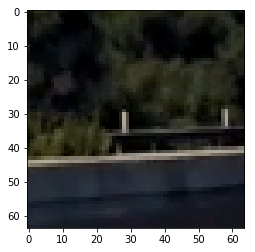

In [3]:
index = random.randint(0, len(notcars))
tmp_img = cv2.imread(notcars[index])
tmp_image = cv2.cvtColor(tmp_img, cv2.COLOR_BGR2RGB)
plt.imshow(tmp_image)

## Combine and Normalize Features

In [4]:
def Convert2RGB(imagelists):
    images = []
    # Convert to grayscale
    for fname in imagelists:
        tmpimg = cv2.imread(fname)
        image = cv2.cvtColor(tmpimg, cv2.COLOR_BGR2RGB)
        images.append(image)
        
    return images

def convert_color(img, conv='RGB2YCrCb'):
    if conv == 'RGB2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    if conv == 'BGR2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_BGR2YCrCb)
    if conv == 'RGB2LUV':
        return cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
    if conv == 'RGB2YUV':
        return cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
    
# Define a function to compute binned color features  
def bin_spatial(img, size=(32, 32)):
    #features = cv2.resize(img, size).ravel()
    color0 = cv2.resize(img[:,:,0], size).ravel()        
    color1 = cv2.resize(img[:,:,1], size).ravel()
    color2 = cv2.resize(img[:,:,2], size).ravel()
    return np.hstack((color0, color1, color2))

# Define a function to compute color histogram features  
def color_hist(img, nbins=32, bins_range=(0, 256)):
    channel0_hist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    channel1_hist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    channel2_hist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    hist_features = np.concatenate((channel0_hist[0], channel1_hist[0], channel2_hist[0]))
    return hist_features

def color_hist_default(img, nbins=32):
    channel0_hist = np.histogram(img[:,:,0], bins=nbins)
    channel1_hist = np.histogram(img[:,:,1], bins=nbins)
    channel2_hist = np.histogram(img[:,:,2], bins=nbins)
    hist_features = np.concatenate((channel0_hist[0], channel1_hist[0], channel2_hist[0]))
    return hist_features

from skimage.feature import hog

# Define a function to return HOG features and visualization
def get_hog_features(img, orient, pix_per_cell, cell_per_block, vis=False, feature_vec=True):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=True, 
                                  block_norm='L2-Hys', visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=True, 
                       block_norm='L2-Hys', visualise=vis, feature_vector=feature_vec)
        return features

# Define a function to extract features from a list of images
def extract_features(imgs, cspace='RGB', spatial_size=(32,32), hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0):
    features = []
    
    for file in imgs:
        feature_collections = []
        read_image = cv2.imread(file)
        image = cv2.cvtColor(read_image, cv2.COLOR_BGR2RGB)
        if cspace != 'RGB':
            if cspace == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif cspace == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif cspace == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif cspace == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
            elif cspace == 'YCrCb':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
        else:
            feature_image = np.copy(image)
            
        spatial_features = bin_spatial(feature_image, size=spatial_size)
        feature_collections.append(spatial_features)
        
        hist_features = color_hist_default(feature_image, nbins=hist_bins)
        feature_collections.append(hist_features)
        
        #features.append(np.concatenate((spatial_feature, hist_features)))
        
        # Call get_hog_features() with vis=False, feature_vec=True
        hog_features = []
        if hog_channel == 'ALL':
            for channel in range(feature_image.shape[2]):
                hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                    orient, pix_per_cell, cell_per_block, vis=False, feature_vec=True))
            hog_features = np.ravel(hog_features)        
        else:
            hog_features, hog_image = get_hog_features(feature_image[:,:,hog_channel], orient, 
                                    pix_per_cell, cell_per_block, vis=False, feature_vec=True)
            
        feature_collections.append(hog_features)
        
        # Append the new feature vector to the features list
        features.append(np.concatenate(feature_collections))
        
    return features   
    
def extract_single_img_features(img, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0, hog_feature=True, vis=False):    
    img_features = []
    if color_space != 'RGB':
        if color_space == 'HSV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        elif color_space == 'LUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
        elif color_space == 'HLS':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        elif color_space == 'YUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
        elif color_space == 'YCrCb':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    else: feature_image = np.copy(img)      
    
    spatial_features = bin_spatial(feature_image, size=spatial_size)
    img_features.append(spatial_features)
        
    hist_features = color_hist_default(feature_image, nbins=hist_bins)
    img_features.append(hist_features)
    
    #hog_features = []  
    #hog_image = []
    if hog_feature == True:
        if hog_channel == 'ALL':
            hog_features = []   
            for channel in range(feature_image.shape[2]):                
                hog_features.extend(get_hog_features(feature_image[:,:,channel], 
                                    orient, pix_per_cell, cell_per_block, 
                                    vis=False, feature_vec=True))                 
        else:            
            if vis == True:
                hog_features, hog_image = get_hog_features(feature_image[:,:,hog_channel], orient, 
                        pix_per_cell, cell_per_block, vis=True, feature_vec=True)
                hog_features = np.ravel(hog_features)
            else:
                hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                        pix_per_cell, cell_per_block, vis=False, feature_vec=True)
                hog_features = np.ravel(hog_features)
       
        img_features.append(hog_features)
        
    if vis == True:
        return np.concatenate(img_features), hog_image
    else:
        return np.concatenate(img_features)
    
print('Done...')

Done...


## test the feature extract

original image shape  is:  (64, 64, 3)


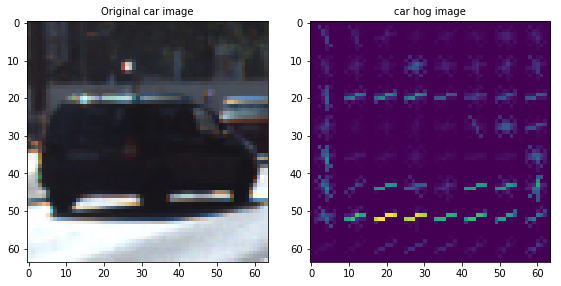

In [33]:
from sklearn.preprocessing import StandardScaler
test = cv2.imread(cars[1])
print('original image shape  is: ',test.shape)

car_index = random.randint(0, len(cars))
car_img = mpimg.imread(cars[car_index])

notcar_index = random.randint(0, len(notcars))
notcar_img = mpimg.imread(notcars[notcar_index])

colorspace = 'YCrCb' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 9
pix_per_cell = 8
cell_per_block = 2
hog_channel = 0 # Can be 0, 1, 2, or "ALL"
spatial_size = (32, 32) 
hist_bins = 64 

car_features, car_hog_image = extract_single_img_features(car_img, color_space=colorspace, spatial_size=spatial_size,
                        hist_bins=hist_bins, orient=orient, 
                        pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, hog_channel=hog_channel, vis=True) 

notcar_features, notcar_hog_image = extract_single_img_features(notcar_img, color_space=colorspace, spatial_size=spatial_size,
                        hist_bins=hist_bins,  orient=orient, 
                        pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, hog_channel=hog_channel, vis=True)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4))
f.tight_layout()
ax1.imshow(car_img)
ax1.set_title('Original car image', fontsize=10)
ax2.imshow(car_hog_image)
ax2.set_title('car hog image', fontsize=10)



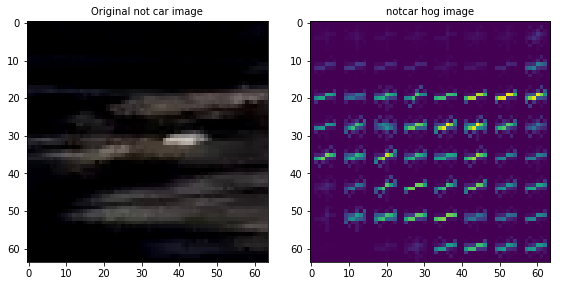

In [34]:
f, (ax3, ax4) = plt.subplots(1, 2, figsize=(8, 4))
f.tight_layout()
ax3.imshow(notcar_img)
ax3.set_title('Original not car image', fontsize=10)
ax4.imshow(notcar_hog_image)
ax4.set_title('notcar hog image', fontsize=10)

## feature extract

In [6]:
colorspace = 'YCrCb' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 9
pix_per_cell = 8
cell_per_block = 2
hog_channel = "ALL" # Can be 0, 1, 2, or "ALL"
spatial_size = (32, 32) 
hist_bins = 64 

train_cars = cars 

import time
t0 = time.time()
print('Begin to extract features...')

car_features = extract_features(train_cars, cspace=colorspace, spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, hog_channel=hog_channel)

if len(car_features) <= 0:
    print('returns empty feature vectors...')
    exit(0)
    
print(round(time.time()-t0, 2), 'Seconds to compute car features...')

print('Done...')

Begin to extract features...
117.31 Seconds to compute car features...
Done...


In [7]:
train_model_file = 'output_model/car_features_model.p'

# dictionary
train_model_dict = {"car_features": car_features}

with open(train_model_file, mode="wb") as f:
    pickle.dump(train_model_dict, f)

print('Done...')

Done...


In [8]:
colorspace = 'YCrCb' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 9
pix_per_cell = 8
cell_per_block = 2
hog_channel = "ALL" # Can be 0, 1, 2, or "ALL"
spatial_size = (32, 32) 
hist_bins = 64 

train_notcars = notcars 
t0 = time.time()

notcar_features = extract_features(train_notcars, cspace=colorspace, spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, hog_channel=hog_channel)

print(round(time.time()-t0, 2), 'Seconds to compute not car features...')

112.17 Seconds to compute not car features...


In [9]:
train_model_file = 'output_model/notcar_features_model.p'
train_model_dict = {"notcar_features": notcar_features}

with open(train_model_file, mode="wb") as f:
    pickle.dump(train_model_dict, f)

print('Done...')

Done...


In [10]:
X = np.vstack((car_features, notcar_features)).astype(np.float64)
X_scaler = StandardScaler().fit(X)

In [11]:
scaled_X = X_scaler.transform(X)


In [12]:
# Define a labels vector based on features lists
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))

## train and test data split

In [13]:
from sklearn.model_selection import train_test_split
# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(scaled_X, y, test_size=0.2, random_state=rand_state)
print("scaled_X length is:   {}".format(len(scaled_X)) )
print("y length is:   {}".format(len(y)) )
print("X_train length is:   {}".format(len(X_train)) )
print("X_test length is:   {}".format(len(X_test)) )
print("y_train length is:   {}".format(len(y_train)) )
print("y_test length is:   {}".format(len(y_test)) )
print('Done ...')

scaled_X length is:   17760
y length is:   17760
X_train length is:   14208
X_test length is:   3552
y_train length is:   14208
y_test length is:   3552
Done ...


## shuffle the training data

In [14]:
from sklearn.utils import shuffle
#shuffle the training set
X_train, y_train = shuffle(X_train, y_train)
print('Done ...')

Done ...


## define and train a classifier

In [18]:
from sklearn.svm import LinearSVC
from sklearn.model_selection import GridSearchCV

import time
parameters = {'C':[1, 10] } 
svr = LinearSVC()
svc = GridSearchCV(svr, parameters)

t = time.time()
svc.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')
print('Test Accuracy of svc= ', round(svc.score(X_test, y_test), 4))
print('best params is: ', svc.best_params_)

# Check the prediction time for a single sample
t0 = time.time()
n_predict = 10
print('My SVC predicts:  ', svc.predict(X_test[0:n_predict]))
print('For labels value: ', y_test[0:n_predict])
t20 = time.time()
print(round(t20-t0, 5), 'Seconds to predict', n_predict,'labels with SVC')
print('Done ...')

108.14 Seconds to train SVC...
Test Accuracy of svc=  0.9887
best params is:  {'C': 1}
My SVC predicts:   [ 1.  0.  1.  1.  1.  1.  0.  0.  0.  0.]
For labels value:  [ 1.  0.  1.  1.  1.  1.  0.  0.  0.  0.]
0.002 Seconds to predict 10 labels with SVC
Done ...


## Pickle the training model

In [19]:
print('Pickle training model and X_scaler...')

train_model_file = 'output_model/train_model.p'

# dictionary
train_model_dict = {"svc": svc, "X_scaler": X_scaler}

with open(train_model_file, mode="wb") as f:
    pickle.dump(train_model_dict, f)

print('Done...')

Pickle training model and X_scaler...
Done...


## Sliding Window Implementation

In [43]:
# draw_boxes function
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # Make a copy of the image
    imcopy = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return imcopy

def slide_window(img, x_start_stop=[None, None], y_start_stop=[None, None], 
                    xy_window=(64, 64), xy_overlap=(0.5, 0.5)):
    # If x and/or y start/stop positions not defined, set to image size
    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None:
        x_start_stop[1] = img.shape[1]
    if y_start_stop[0] == None:
        y_start_stop[0] = 0
    if y_start_stop[1] == None:
        y_start_stop[1] = img.shape[0]
    # Compute the span of the region to be searched    
    xspan = x_start_stop[1] - x_start_stop[0]
    yspan = y_start_stop[1] - y_start_stop[0]
    # Compute the number of pixels per step in x/y
    nx_pix_per_step = np.int(xy_window[0] * (1 - xy_overlap[0]))
    ny_pix_per_step = np.int(xy_window[1] * (1 - xy_overlap[1]))
    # Compute the number of windows in x/y
    nx_buffer = np.int(xy_window[0] * (xy_overlap[0]))
    ny_buffer = np.int(xy_window[1] * (xy_overlap[1]))
    nx_windows = np.int((xspan-nx_buffer)/nx_pix_per_step) 
    ny_windows = np.int((yspan-ny_buffer)/ny_pix_per_step) 
    # Initialize a list to append window positions to
    window_list = []
    # Loop through finding x and y window positions
    # Note: you could vectorize this step, but in practice
    # you'll be considering windows one by one with your
    # classifier, so looping makes sense
    for ys in range(ny_windows):
        for xs in range(nx_windows):
            # Calculate window position
            startx = xs * nx_pix_per_step + x_start_stop[0]
            endx = startx + xy_window[0]
            starty = ys * ny_pix_per_step + y_start_stop[0]
            endy = starty + xy_window[1]
            # Append window position to list
            window_list.append(((startx, starty), (endx, endy)))
    # Return the list of windows
    return window_list

def search_windows(img, windows, clf, scaler, color_space='RGB', spatial_size=(32, 32), hist_bins=32, 
                    hist_range=(0, 256), orient=9, pix_per_cell=8, cell_per_block=2, hog_channel=0):
    on_windows = []
    for window in windows:
        test_img = cv2.resize(img[window[0][1]:window[1][1], window[0][0]:window[1][0]], (64, 64))
        
        features = extract_single_img_features(test_img, color_space=color_space, spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, hog_feature=True,  vis=False)

        test_features = scaler.transform(np.array(features).reshape(1, -1))
        prediction = clf.predict(test_features)
        if prediction == 1:
            on_windows.append(window)

    return on_windows


def find_cars(image, ystart, ystop, scale_list, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins):
    
    vehicle_detection_windows = []
    xstart = 500
    for cur_scale in scale_list: 
        #image = image.astype(np.float32)/255   
        img_tosearch = image[ystart:ystop, xstart:, :]
        ctrans_tosearch = convert_color(img_tosearch, conv='RGB2YCrCb')
    
        if cur_scale != 1:
            imshape = ctrans_tosearch.shape
            ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/cur_scale), np.int(imshape[0]/cur_scale)))
        
        ch1 = ctrans_tosearch[:,:,0]
        ch2 = ctrans_tosearch[:,:,1]
        ch3 = ctrans_tosearch[:,:,2]

        # Define blocks and steps as above
        nxblocks = (ch1.shape[1] // pix_per_cell) - cell_per_block +  1
        nyblocks = (ch1.shape[0] // pix_per_cell) - cell_per_block + 1
        nfeat_per_block = orient * (cell_per_block**2)
    
        # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
        window = 64
        nblocks_per_window = (window // pix_per_cell) - cell_per_block + 1
        cells_per_step = 2  # Instead of overlap, define how many cells to step
        nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
        nysteps = (nyblocks - nblocks_per_window) // cells_per_step

        # Compute individual channel HOG features for the entire image
        hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
        hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
        hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)
    
        for xb in range(nxsteps):
            for yb in range(nysteps):
                ypos = yb*cells_per_step
                xpos = xb*cells_per_step
                # Extract HOG for this patch
                hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
                hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
                hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
                hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))

                xleft = xpos*pix_per_cell
                ytop = ypos*pix_per_cell

                # Extract the image patch
                subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))

                # Get color features
                spatial_features = bin_spatial(subimg, size=spatial_size)
                hist_features = color_hist(subimg, nbins=hist_bins)

                # Scale features and make a prediction
                test_features = X_scaler.transform(np.hstack((spatial_features, hist_features, hog_features)).reshape(1, -1))    
                #test_features = X_scaler.transform(np.hstack((shape_feat, hist_feat)).reshape(1, -1))    
                test_prediction = svc.predict(test_features)

                if ( (test_prediction) == 1 and ((svc.decision_function(test_features) > 0.9))):
                    xbox_left = np.int(xleft * cur_scale)
                    ytop_draw = np.int(ytop * cur_scale)
                    win_draw = np.int(window * cur_scale)                
                    vehicle_detection_windows.append(((xbox_left+xstart, ytop_draw+ystart),(xbox_left+win_draw+xstart, ytop_draw+win_draw+ystart)))

    return vehicle_detection_windows

print('Done...')

Done...


## Test the vehicle detection in test images directory

Done...


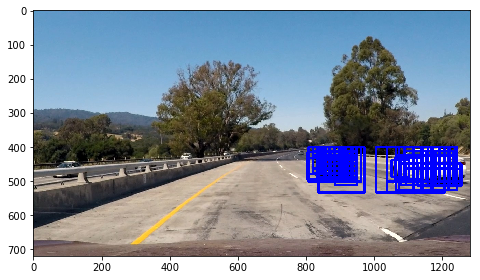

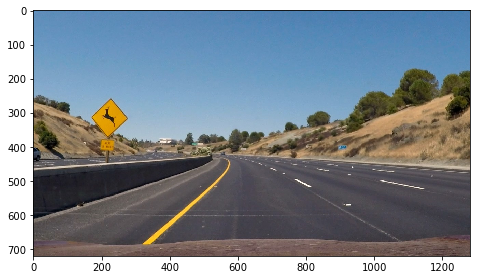

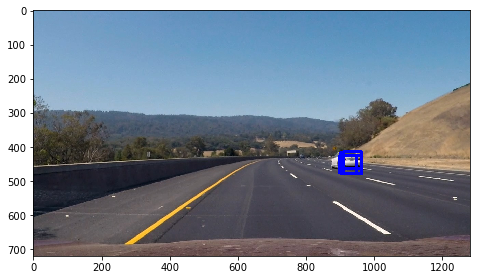

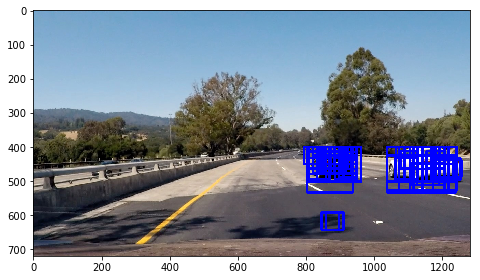

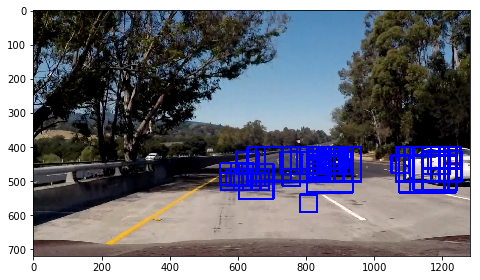

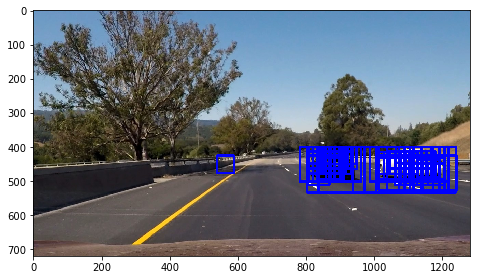

In [44]:
test_path = 'test_images/test*'
test_images = glob.glob(test_path)

y_start_stop = [400, 656]
xyoverlap = (0.5, 0.5)
xy_window = (64, 64)
color_space = 'YCrCb'
orient = 9
pix_per_cell = 8
cell_per_block = 2
hog_channel = "ALL" # Can be 0, 1, 2, or "ALL"
spatial_size = (32, 32) 
hist_bins = 64 
scale_list = [2.1, 1.6, 1.0, 0.8] #window scales
search_windows = []

#print(svc)

for img_path in test_images:
    img = cv2.imread(img_path) 
    image = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    #image = convert_color(image, conv='RGB2YCrCb')
    #draw_image = np.copy(image)
    #image = image.astype(np.float32)/255
    
    #windows = slide_window(image, x_start_stop=[None,None], y_start_stop=y_start_stop, 
    #                xy_window=xy_window, xy_overlap=xyoverlap)
                       
    search_windows = find_cars(image, y_start_stop[0], y_start_stop[1], scale_list, svc, X_scaler, orient, pix_per_cell, 
                               cell_per_block, spatial_size, hist_bins)
    #print(search_windows)
    
    window_img = draw_boxes(image, search_windows, color=(0, 0, 255), thick=6)  
    f, (ax1) = plt.subplots(1, 1, figsize=(8, 4))
    f.tight_layout()
    #ax1.imshow(cv2.cvtColor(window_img, cv2.COLOR_YCrCb2RGB))
    ax1.imshow(window_img)

print('Done...')

## Define Heat Maps

In [29]:
def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap# Iterate through list of bboxes
    
def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

def draw_labeled_bboxes(img, labels):
    draw_image = np.copy(img)
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(draw_image, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image
    return draw_image

print('Done...')

Done...


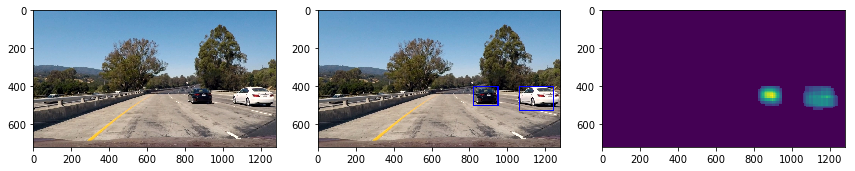

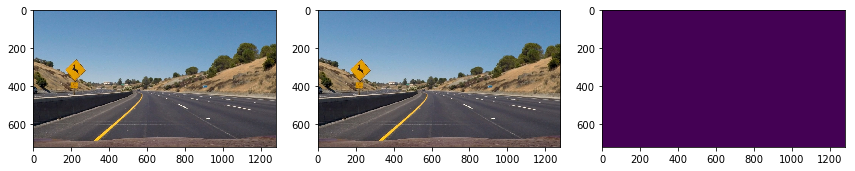

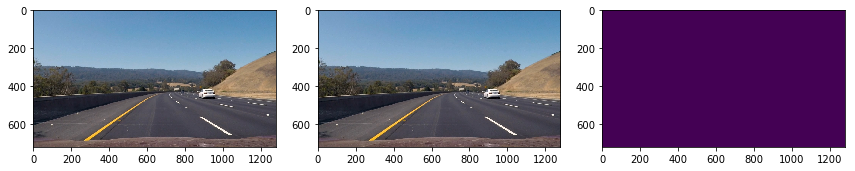

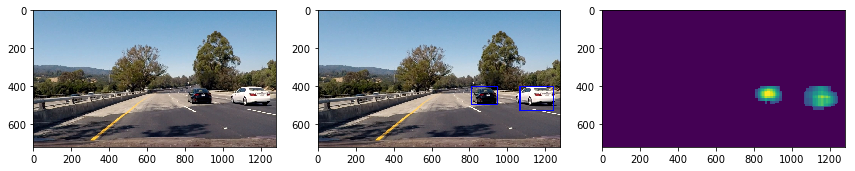

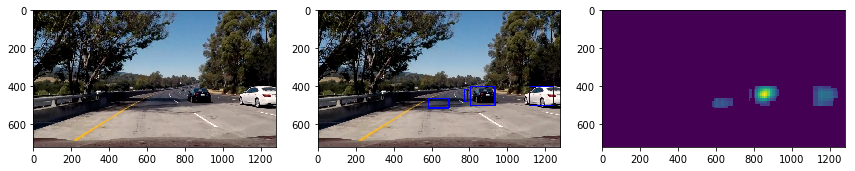

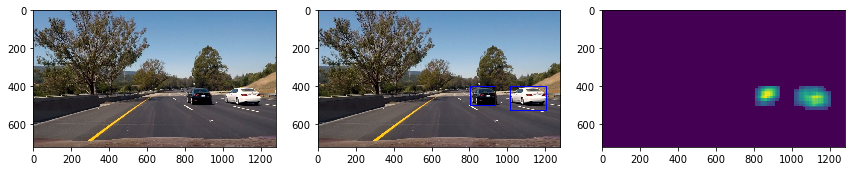

In [45]:
from scipy.ndimage.measurements import label

scale_list = [2.1, 1.6, 1.0, 0.8] 
draw_img_list = []
heat_map_list = []
original_img_list = []

# Iterate over test images
for img in test_images:
    img = cv2.imread(img)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    original_img_list.append(img)
    
    heatmap = np.zeros_like(img[:,:,0]).astype(np.float32)  
    #draw_img = np.copy(img)
    box_list = find_cars(img, y_start_stop[0], y_start_stop[1], scale_list, svc, X_scaler, orient, pix_per_cell, 
                         cell_per_block, spatial_size, hist_bins)
    
    heatmap = add_heat(heatmap, box_list)
    heatmap = apply_threshold(heatmap, 4)
    heat_map_list.append(heatmap)
    labels_obj = label(heatmap) 
    draw_img = draw_labeled_bboxes(img, labels_obj)
    draw_img_list.append(draw_img)

for i in range(0, len(original_img_list)):
    f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12, 4))
    f.tight_layout()
    ax1.imshow(original_img_list[i])
    ax2.imshow(draw_img_list[i])
    ax3.imshow(heat_map_list[i])

## Process procedure

In [46]:
def process_images(img):
    draw_img = np.copy(img)  
    global heatmap
    heatmap = np.zeros_like(img[:,:,0]).astype(np.float)  
    
    ystart = 400
    ystop = 656
    scale_list = [2.1, 1.6, 1.0, 0.8] 
    spatial_size = (32, 32)
    hist_bins = 64
    orient = 9
    pix_per_cell = 8
    cell_per_block = 2
    
    box_list = find_cars(img, ystart, ystop, scale_list, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)

    if (len(box_list)) != 0:
        heatmap = add_heat(heatmap, box_list)
        heatmap = apply_threshold(heatmap, 4)
        labels_obj = label(heatmap) 
        draw_img = draw_labeled_bboxes(draw_img, labels_obj)

    return draw_img

print('Done...')

Done...


## Process project video

In [47]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

test_output = 'project_video_output.mp4'
clip = VideoFileClip("project_video.mp4")
test_clip = clip.fl_image(process_images)
#%time
test_clip.write_videofile(test_output, audio=False)

[MoviePy] >>>> Building video project_video_output.mp4
[MoviePy] Writing video project_video_output.mp4


100%|███████████████████████████████████████████████████████████████████████████▉| 1260/1261 [1:08:24<00:03,  3.32s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_output.mp4 

